## Red Neuronal para clasificar imágenes 
Torch posee dos paquetes adicionales muy útiles para trabajar. El primero es torchvision, que permite el trato con imágenes, el segundo es utils.data que permite reducir mucho código genérico para el trato de los datos.

Para este ejemplo, vamos a utilizar el dataset de CIFAR10 
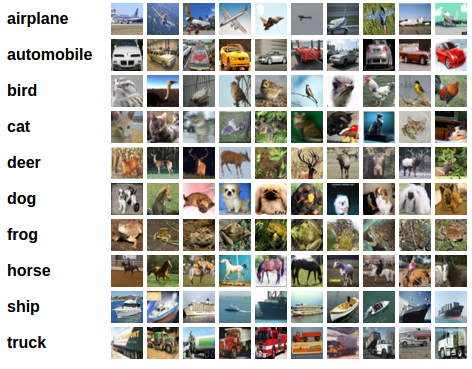

Para entrenar el clasificador de imágenes vamos a realizar los siguientes pasos:
- Cargar y normalizar los datos de CIFAR10 usando torchvision
- Definir una red convolucional
- Definir una función de pérdida
- Entrenar la red con los datos de training
- Testear la precisión de la red con los datos de test

#### Vamos a ello!

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Transformamos las PIL images de rango [0, 1] a tensores normalizados de valor [-1, 1]

In [2]:

#Definiendo la normalizacion que se debe hacer posterior
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

##Data set de Entrenamiento
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

##Data set de prueba
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)



###Clases de las imagenes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Mostremos alguna de las imágenes

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 640x480 with 1 Axes>

  car horse truck horse


Definimos la red convolucional

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

Definimos la función de pérdida

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Entrenamos la red

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.238
[1,  4000] loss: 1.931
[1,  6000] loss: 1.735
[1,  8000] loss: 1.634
[1, 10000] loss: 1.552
[1, 12000] loss: 1.484
[2,  2000] loss: 1.410
[2,  4000] loss: 1.387
[2,  6000] loss: 1.378
[2,  8000] loss: 1.341
[2, 10000] loss: 1.330
[2, 12000] loss: 1.308
Finished Training


Testeamos la red que hemos creado

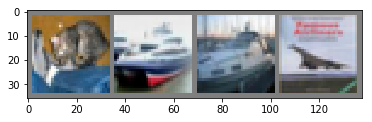

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Ahora veamos que predice nuestra red con algunas muestras

In [9]:
outputs = net(images)

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat truck truck  ship


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


Aunque parece bajo, es mucho mejor que aleatoriamente que sería un 10%. Es una buena red. Veamos las clases que tienen más precisión y las que tienen menos

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 55 %
Accuracy of  bird : 49 %
Accuracy of   cat : 24 %
Accuracy of  deer : 29 %
Accuracy of   dog : 52 %
Accuracy of  frog : 76 %
Accuracy of horse : 57 %
Accuracy of  ship : 62 %
Accuracy of truck : 78 %


In [2]:
print(range[2])

TypeError: 'type' object is not subscriptable